In [2]:
##PV and GPH joint

In [3]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

/tmp/ipykernel_155068/3801934532.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

2024-12-03 18:04:13.486212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 18:04:13.486281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 18:04:13.486322: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 18:04:13.492714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tf.compat.v1.disable_eager_execution()
import innvestigate
import investigate

In [6]:
from climoprobs import climo

#### Upload data. 

In [7]:
#inputs
##now, PVU
infile = open("../data/1203_pv.p", 'rb') 
pvu = pickle.load(infile)
infile.close()

infile = open("../data/1203_g.p", 'rb') 
gph = pickle.load(infile)
infile.close()

#outputs
infile = open("../data/1203_classmedian_t.p", 'rb')
temp = pickle.load(infile)
infile.close()

infile = open("../data/1203_classmedian_g.p", 'rb')
gph_red = pickle.load(infile)
infile.close()

In [8]:
pvu.shape

(63, 151, 11, 145)

In [9]:
length = 146
end_pv = 146
end_gph = 151

In [10]:
gph_n = np.zeros((63,length))
input_pvu = np.zeros((63,length,11,145))

for i in range(63):
    for j in range(5,end_pv):
        gph_n[i,j-5] = gph_red[i,j]
        input_pvu[i,j-5] = pvu[i,j-5,:,:]

In [11]:
temp_n = np.zeros((63,length))
input_gph= np.zeros((63,length,21,37))

for i in range(63):
    for j in range(10,end_gph):
        #print(j)
        temp_n[i,j-10] = temp[i,j]
        input_gph[i,j-10] = gph[i,j-5,:,:]

In [12]:
##input shape (samples, lat, lon) and (#samples, window, features)
print(input_gph.shape)
print(input_pvu.shape)

(63, 146, 21, 37)
(63, 146, 11, 145)


In [13]:
##output shape (samples), these will be different from the input
gph_n.shape

(63, 146)

In [14]:
train_edge = int((63*length) - ((63*length)/63)*4)

test_frac = int(((63*length)/63)*6)

In [15]:
##Set X_all and Y_all datasets
X_all1 = np.copy(input_pvu.reshape(63*length,11*145)) ##pvu
Y_all1 = np.copy(gph_n.reshape(63*length))

X_all2 = np.copy(input_gph.reshape(63*length,21*37)) ##gph
Y_all2 = np.copy(temp_n.reshape(63*length))

##training data partition out
X_tri1 = X_all1[:train_edge,:] ##pvu
Y_tri1 = Y_all1[:train_edge]

X_tri2 = X_all2[:train_edge,:] ##gph
Y_tri2 = Y_all2[:train_edge]

#testing data partition out
X_tes1 = X_all1[train_edge:,:]
Y_tes1 = Y_all1[train_edge:]

X_tes2 = X_all2[train_edge:,:]
Y_tes2 = Y_all2[train_edge:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all1 = keras.utils.to_categorical(Y_all1)
Y_tri1 = keras.utils.to_categorical(Y_tri1)
Y_tes1= keras.utils.to_categorical(Y_tes1)

Y_all2 = keras.utils.to_categorical(Y_all2)
Y_tri2 = keras.utils.to_categorical(Y_tri2)
Y_tes2= keras.utils.to_categorical(Y_tes2)

In [16]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all2)) or np.any(np.isinf(X_all2)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all2)) or np.any(np.isinf(Y_all2)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [17]:
##set 6 years of data for validation
frac_ind = test_frac 
frac_ind

876

In [18]:
##checking to make sure shape was properly one hot encoded
Y_all2.shape

(9198, 2)

In [19]:
Y_all1.shape

(9198, 2)

In [20]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [21]:
##number of input nodes
input_shape1=  X_all1.shape[-1] # pvu
input_shape2= X_all2.shape[-1] ## gph

##fraction of training data
X_validation1 = X_tri1[0:frac_ind]
Y_validation1 = Y_tri1[0:frac_ind]
X_validation2 = X_tri2[0:frac_ind]
Y_validation2 = Y_tri2[0:frac_ind]
        
X_train1 = X_tri1[frac_ind:len(X_tri1)]
Y_train1 = Y_tri1[frac_ind:len(Y_tri1)]
X_train2 = X_tri2[frac_ind:len(X_tri2)]
Y_train2 = Y_tri2[frac_ind:len(Y_tri2)]

X_test1 = X_tes1
Y_test1 = Y_tes1
X_test2 = X_tes2
Y_test2 = Y_tes2

In [22]:
Y_train2.shape

(7738, 2)

In [23]:
input_shape1

1595

In [24]:
input_shape2

777

In [25]:
##do the class_dict weights
class_weight1 = class_weight_creator(Y_train1)
class_weight1

{0: 1.0, 1: 1.0987252}

In [26]:
class_weight2 = class_weight_creator(Y_train2)
class_weight2

{0: 1.0, 1: 1.1902066}

In [27]:
##dictionaries for training and validation
X_train = {'model1': X_train1, 'model2': X_train2}
X_all = {'model1': X_all1, 'model2': X_all2}
X_test = {'model1': X_test1, 'model2': X_test2}
X_val = {'model1': X_validation1, 'model2': X_validation2}

Y_train = {'output1': Y_train1, 'output2': Y_train2}
Y_all = {'output1': Y_all1, 'output2': Y_all2}
Y_test = {'output1': Y_test1, 'output2': Y_test2}
Y_val = {'output1': Y_validation1, 'output2': Y_validation2}

class_weight = {'output1': class_weight1, 'output2': class_weight2}

### Model Arcitecture.

In [28]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [ ]:
#############################tuning#############################

In [34]:
def combined(hp):
    ##set ranges for hyperparameters
    n1 = hp.Int('n1', min_value=120, max_value=128, step=4)
    n2 = hp.Int('n2', min_value=4, max_value=16, step=4)
    n3= hp.Int('n3', min_value=120, max_value=128, step=4)
    n4 = hp.Int('n4', min_value=4, max_value=16, step=4)

    reg1 = hp.Float('reg1', min_value=0.01, max_value=1, default=0.01)
    reg2 = hp.Float('reg2', min_value=0.001, max_value=0.1, default=0.01)
    reg3 = hp.Float('reg3', min_value=0.01, max_value=1, default=0.01)
    reg4 = hp.Float('reg4', min_value=0.001, max_value=0.1, default=0.01)
    
    ##first layers for PVU ANN
    input_tensor1 = Input(shape=(int(1595),), name='model1')
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   
    layer1 = layers.Dense(n2, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
    output_tensor1 = layers.Dense(2,activation='softmax', name='output1')(layer1)
    

    ## second layers for GPH ANN
    input_tensor2 = Input(shape=(int(777),), name='model2')
    
    repeated = layers.RepeatVector(777)(output_tensor1)
    #flatten output_tensor1_
    flattened = layers.Flatten()(repeated)
    combined = layers.Concatenate(axis=-1)([input_tensor2, flattened])
    
    layer2 = layers.Dense(n3, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(combined)
    layer2 = layers.Dense(n4, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)

    output_tensor2 = layers.Dense(2,activation='softmax', name='output2')(layer2)
    
    model = Model([input_tensor1, input_tensor2], output_tensor2)

    lr = hp.Float('learning_rate', min_value=1e-3, max_value=1, default=1e-3)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=lr),
              loss = {"output2":"categorical_crossentropy"}
              , #Our loss function is based on categorical error
             metrics={'output2': keras.metrics.categorical_accuracy}, #We will print out the categorical accuracy as the network is trained
              )
    return model

In [47]:
##intialize/setup the hyperband tuner
import keras_tuner as kt

tuner = kt.tuners.RandomSearch(
    combined, #model
    objective = [kt.Objective('val_loss', 'min'), kt.Objective('loss', 'min'),
                kt.Objective('val_categorical_accuracy', 'max')], #target
    max_trials=1000, #number of iterations of tuning to run
    max_consecutive_failed_trials=3, #number of allowed failed trials
    directory = 'tuning',
    project_name='joint1'
)

Reloading Tuner from tuning/joint1/tuner0.json


In [48]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [49]:
##actual tuning process
tuner.search(X_train, Y_train, validation_data=(X_val, Y_val),
             batch_size=batch_size, epochs=epochs, shuffle=shuffle,
             class_weight = class_weight, callbacks=[stop_early])

In [50]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('n1')}, the second is {best_hps.get('n2')},
regularizers are {best_hps.get('reg1')} and {best_hps.get('reg2')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 124, the second is 4,
regularizers are 0.7399673295339388 and 0.09789143529456881,
and the optimal learning rate for the optimizer
is 0.0016438185261663922.



In [51]:
best_hps.values

{'n1': 124,
 'n2': 4,
 'n3': 120,
 'n4': 12,
 'reg1': 0.7399673295339388,
 'reg2': 0.09789143529456881,
 'reg3': 0.020660636780558586,
 'reg4': 0.055811274881584355,
 'learning_rate': 0.0016438185261663922}

In [52]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train,Y_train, validation_data=(X_val, Y_val),
                    batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight)

Train on 7738 samples, validate on 876 samples
Epoch 1/50
 256/7738 [..............................] - ETA: 1s - loss: 191.2866 - categorical_accuracy: 0.4961

2024-12-03 21:36:11.010988: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_18/bias/v/Assign' id:3077 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_18/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_18/bias/v, training_4/Adam/dense_18/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7738/7738 [==============================] - 0s 48us/sample - loss: 73.0121 - categorical_accuracy: 0.6154 - val_loss: 11.9539 - val_categorical_accuracy: 0.6518
Epoch 2/50
7738/7738 [==============================] - 0s 28us/sample - loss: 4.5124 - categorical_accuracy: 0.6431 - val_loss: 1.4956 - val_categorical_accuracy: 0.6279
Epoch 3/50
7738/7738 [==============================] - 0s 28us/sample - loss: 1.2202 - categorical_accuracy: 0.6427 - val_loss: 0.9453 - val_categorical_accuracy: 0.6712
Epoch 4/50
7738/7738 [==============================] - 0s 29us/sample - loss: 0.9325 - categorical_accuracy: 0.6437 - val_loss: 0.7984 - val_categorical_accuracy: 0.6655
Epoch 5/50
7738/7738 [==============================] - 0s 29us/sample - loss: 0.8196 - categorical_accuracy: 0.6379 - val_loss: 0.7144 - val_categorical_accuracy: 0.6667
Epoch 6/50
7738/7738 [==============================] - 0s 29us/sample - loss: 0.7756 - categorical_accuracy: 0.6247 - val_loss: 0.6864 - val_categorical_

2024-12-03 21:36:22.570862: W tensorflow/c/c_api.cc:305] Operation '{name:'output2_4/Softmax' id:2638 op device:{requested: '', assigned: ''} def:{{{node output2_4/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output2_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

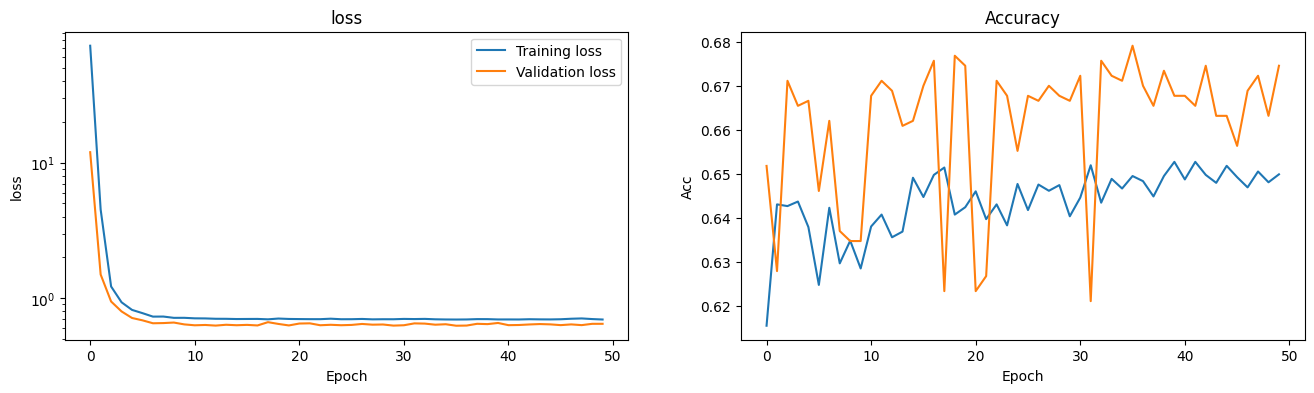

In [53]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_val)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend